# 데이터 로딩

In [1]:
from datasets import load_dataset
import pandas as pd
from pathlib import Path

In [2]:
# text: subject + " " + message를 공백으로 이어 붙여 만든 분류용 본문(제목과 본문을 합친 텍스트).
ds = load_dataset("SetFit/enron_spam")  # splits: 'train', 'test'
print(ds)  # 구조 확인용

Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
        num_rows: 31716
    })
    test: Dataset({
        features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
        num_rows: 2000
    })
})


In [3]:
# 저장 폴더 준비
dir_store = Path("temp/enron_spam")
dir_store.mkdir(parents=True, exist_ok=True)

In [4]:
# 각 스플릿을 CSV로 저장
for split in ds.keys():  # 'train', 'test'
    df = ds[split].to_pandas()
    df.to_csv(dir_store / f"enron_spam_{split}.csv", index=False)

In [6]:
print("Saved to:", list(dir_store.glob("*.csv")))

Saved to: [PosixPath('temp/enron_spam/enron_spam_train.csv'), PosixPath('temp/enron_spam/enron_spam_test.csv')]


# 기본 환경 설정

In [7]:
import os, re, random, math, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [8]:
# 환경 변수
RANDOM_SEED = 42
DATA_DIR = Path("temp")
TRAIN_CSV = DATA_DIR / "enron_spam/enron_spam_train.csv"
TEST_CSV  = DATA_DIR / "enron_spam/enron_spam_test.csv"
OUT_DIR = DATA_DIR / "eron_outputs"

In [9]:
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [10]:
# 재현 가능성(reproducibility)을 위해 실험마다 동일한 난수를 쓰도록 고정값 설정
torch.manual_seed(RANDOM_SEED) # PyTorch의 CPU 난수 시드(가중치 초기화, dropout 등 torch CPU 연산에서 쓰는 난수에 영향)
torch.cuda.manual_seed_all(RANDOM_SEED) # 모든 GPU(CUDA 디바이스)의 난수 시드(드롭아웃, 일부 커널 내부 샘플링 등 CUDA 연산에 영향)
np.random.seed(RANDOM_SEED) # NumPy 난수 시드(전처리/샘플링에 NumPy를 사용할 때 결과를 고정)
random.seed(RANDOM_SEED) # Python 표준 random 모듈의 시드(데이터 셔플 등 random 모듈 사용 코드의 결과를 고정)
# cuDNN이 비결정적(non-deterministic) 알고리즘을 쓰지 못하게 강제
#  - 장점: 같은 입력과 시드로 항상 같은 출력(결정적 결과)
#  - 단점: 일부 연산이 느려질 수 있음
torch.backends.cudnn.deterministic = True
# 입력 크기별로 가장 빠른 알고리즘을 자동 탐색(benchmark)하는 기능 비활성화
#  - 켜두면 실행마다 선택된 알고리즘이 달라져 결과가 흔들릴 수 있어 재현성 저하
#  - 끄면 속도는 손해 볼 수 있지만 알고리즘 선택이 고정되어 재현성 향상
torch.backends.cudnn.benchmark = False

# EDA

## 데이터 로드

In [11]:
df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)

In [12]:
df_train.head()

,message_id,text,label,label_text,subject,message,date
0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18
1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19
2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11
3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12
4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13


## 결측 제거

In [13]:
df_train = df_train.dropna(subset=["text","label"]).reset_index(drop=True)
df_test = df_test.dropna(subset=["text","label"]).reset_index(drop=True)

## 추가 Feature 생성

In [14]:
# 텍스트 길이(문자수) & 라인수
df_train["char_len"] = df_train["text"].str.len()
df_train["line_cnt"] = df_train["text"].str.count("\n") + 1
df_test["char_len"] = df_test["text"].str.len()
df_test["line_cnt"] = df_test["text"].str.count("\n") + 1

In [15]:
# 간단 Subject 추출 (본문 맨 처음 줄이 'Subject:' 패턴인 경우)
def extract_subject(s):
    if not isinstance(s, str):
        return None
    m = re.match(r"(?i)^subject:\s*(.*)", s.splitlines()[0]) if s else None
    return m.group(1).strip() if m else s

In [16]:
df_train["subject"] = df_train["text"].apply(extract_subject)
df_test["subject"] = df_test["text"].apply(extract_subject)

In [17]:
df_train.head()

,message_id,text,label,label_text,subject,message,date,char_len,line_cnt
0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $ understandin...,understanding oem software\nlead me not into t...,2005-06-18,156,3
1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19,1112,27
2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11,242,5
3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000 tec...",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12,127,2
4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13,329,4


In [18]:
df_train["label"].value_counts(normalize=True) # 빈도수 대신 비율(각 값의 등장 횟수 ÷ 전체 개수)을 반환

label
1    0.508827
0    0.491173
Name: proportion, dtype: float64

# 길이(문자수) 분포 시각화

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
sns.set_theme(style="whitegrid", context="notebook", rc={
    "axes.spines.top": False,
    "axes.spines.right": False,
})

In [71]:
def plotCharLengthDistribution(df, col="char_len", up_bound=20_000):
    data = df[col].clip(upper=up_bound)
    plt.figure(figsize=(8, 3))
    ax = sns.histplot(data=data, bins=50, stat="percent")

    median = data.median()
    mean = data.mean()
    q95 = data.quantile(0.95)
    ax.axvline(median, ls="--", lw=1, color="red", label=f"median = {median:.0f}")
    ax.axvline(mean,   ls=":",  lw=1, color="red", label=f"mean = {mean:.0f}")
    ax.axvline(q95,    ls="-.", lw=1, color="red", label=f"quantile 95 = {q95:.0f}")

    ax.set_title("Character length distribution (train)", pad=10)
    ax.set_xlabel(col)
    ax.set_ylabel("percent")
    ax.legend(loc="upper right", frameon=False)

    plt.show()

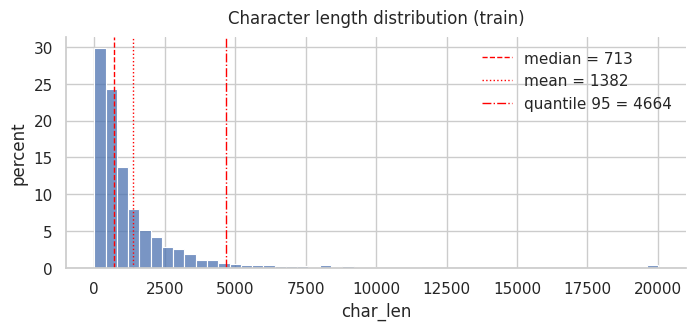

In [72]:
plotCharLengthDistribution(df_train, "char_len", 20_000)

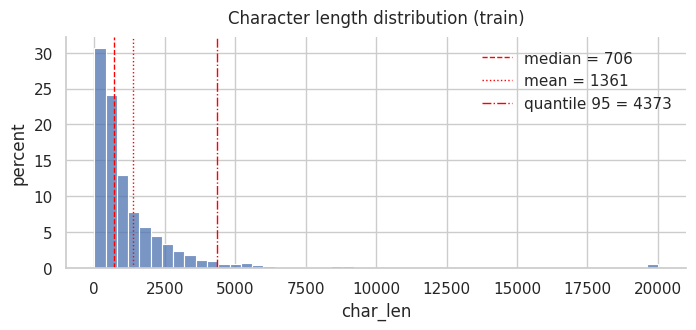

In [73]:
plotCharLengthDistribution(df_test, "char_len")

# 토크나이징 (글자 -> 숫자)

In [24]:
import sentencepiece as spm
from collections import Counter

In [25]:
SPM_DIR = OUT_DIR / "tokenizer"
SPM_DIR.mkdir(parents=True, exist_ok=True)
SPM_PREFIX = str(SPM_DIR / "enron_tokenizer")

In [26]:
sp_input_path = SPM_DIR / "spm_input_train.txt"
df_train["text"].to_csv(sp_input_path, index=False, header=False)

In [27]:
spm.SentencePieceTrainer.Train(
    input=str(sp_input_path),
    model_prefix=SPM_PREFIX,
    vocab_size=8000,
    model_type="unigram",              # 또는 "bpe"
    character_coverage=0.9995,         # 영문 위주라 0.9995, 멀티언어면 1.0 권장
    user_defined_symbols=["<|PAD|>"],
    input_sentence_size=200000,        # 대용량일 경우 샘플링
    shuffle_input_sentence=True
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: temp/eron_outputs/tokenizer/spm_input_train.txt
  input_format: 
  model_prefix: temp/eron_outputs/tokenizer/enron_tokenizer
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 200000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <|PAD|>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_

In [28]:
tokenizer_sp = spm.SentencePieceProcessor()
tokenizer_sp.load(SPM_PREFIX + ".model")
print("SentencePiece vocab size:", tokenizer_sp.get_piece_size())

SentencePiece vocab size: 8000


In [29]:
def sp_pieces(text):
    return tokenizer_sp.encode_as_pieces(text) if isinstance(text, str) else []

In [30]:
df_train["tok_len"] = df_train["text"].apply(lambda x: len(sp_pieces(x)))
df_test["tok_len"]  = df_test["text"].apply(lambda x: len(sp_pieces(x)))

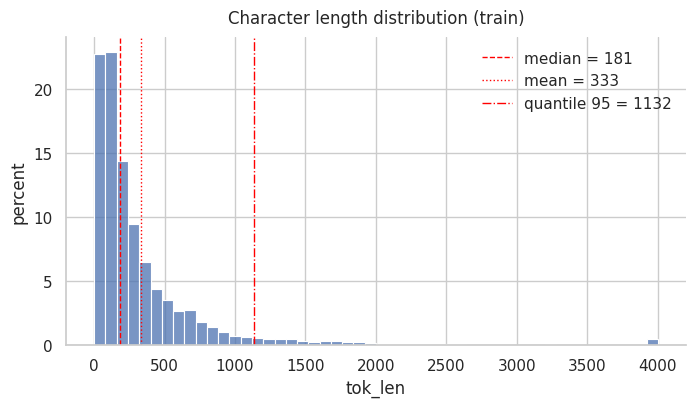

In [31]:
plotCharLengthDistribution(df_train, "tok_len", 4_000)

In [33]:
sample_for_freq = df_train.sample(n=min(5000, len(df_train)), random_state=RANDOM_SEED)
cnt = Counter(tok for txt in sample_for_freq["text"] for tok in sp_pieces(txt))
top20 = cnt.most_common(50)
print("Top 20 tokens:", top20)

Top 20 tokens: [('▁.', 73088), ('▁-', 61639), ('▁,', 53059), ('▁the', 41150), ('▁to', 30599), ('▁/', 25566), ('s', 25534), ('▁:', 25191), ('▁and', 22236), ('▁of', 21022), ('▁a', 19556), ('▁in', 16385), ('▁for', 12563), ('▁you', 11803), ('▁is', 10416), ("▁'", 10194), ('▁s', 10154), ('▁i', 9421), ('▁this', 9214), ('▁_', 9055), ('▁on', 8677), ('▁that', 8180), ('▁)', 7992), ('▁(', 7578), ('▁enron', 7523), ('▁be', 7519), ('▁your', 7043), ('▁"', 7039), ('▁we', 6832), ('▁with', 6792), ('▁@', 6476), ('d', 6359), ('▁!', 6220), ('ing', 6175), ('▁as', 6104), ('▁$', 6071), ('▁will', 5685), ('▁have', 5670), ('▁from', 5630), ('ed', 5618), ('▁it', 5419), ('▁>', 5282), ('▁are', 5249), ('▁?', 5167), ('▁at', 5140), ('▁or', 5070), ('▁ect', 5060), ('▁', 4813), ('▁by', 4442), ('▁;', 4419)]


# 머신러닝 베이스라인 (SentencePiece → TF-IDF → 로지스틱/선형 SVM/나이브베이즈)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import joblib

In [46]:
# train을 다시 train/val 분리 (모델 선택용)
train_texts = df_train["text"].tolist()
train_labels = df_train["label"].astype(int).tolist()
X_tr, X_val, y_tr, y_val = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=RANDOM_SEED, stratify=train_labels
)

In [47]:
# SentencePiece 토크나이저 for sklearn
def sp_tokenizer_for_sklearn(text):
    return sp_pieces(text)

In [70]:
# 공통 TF-IDF (unigram+bigram 권장, 필요시 조정)
# (1,2)나 (1,3)처럼 늘리면 **연속 토큰 패턴(콜로케이션)**을 잡아내 표현력이 증가합니다.
# SentencePiece처럼 서브워드 토큰을 쓸 때는, 바이그램이 실제 “단어” 수준 조합을 어느 정도 복원해 주는 효과가 있어 도움이 되는 경우가 많습니다.
tfidf = TfidfVectorizer(
    tokenizer=sp_tokenizer_for_sklearn,
    lowercase=False,        # SentencePiece는 케이스 정보 유지해도 OK
    preprocessor=None,
    token_pattern=None,     # custom tokenizer 사용시 None
    ngram_range=(1, 2),     # 몇 개의 연속 토큰을 하나의 특징으로 만들지를 정하는 파라미터: uni+bi
    min_df=2,               # document frequency(문서 빈도) 하한선. “최소 몇 개 문서에서 등장한 토큰만 어휘(vocabulary)에 남길 것인가”를 정함.
    max_features=20000
)

In [53]:
Xtr = tfidf.fit_transform(X_tr)
Xva = tfidf.transform(X_val)
Xte = tfidf.transform(df_test["text"].tolist())

In [54]:
# 3-3) 세 가지 분류기 학습 & 검증
models = {
    "logreg": LogisticRegression(max_iter=2000, n_jobs=1),
    "linear_svm": LinearSVC(),
    "mnb": MultinomialNB()
}

In [69]:
Xtr.shape, len(y_tr)

((28498, 20000), 28498)

In [55]:
val_scores = {}
for name, clf in models.items():
    clf.fit(Xtr, y_tr)
    pred_val = clf.predict(Xva)
    acc = accuracy_score(y_val, pred_val)
    val_scores[name] = acc
    print(f"[VAL] {name}: acc={acc:.4f}")

[VAL] logreg: acc=0.9867
[VAL] linear_svm: acc=0.9902
[VAL] mnb: acc=0.9848


In [56]:
best_name = max(val_scores, key=val_scores.get)
best_model = models[best_name]
print("Best on val:", best_name, val_scores[best_name])

Best on val: linear_svm 0.9902115566782443


In [ ]:
# 3-4) 테스트 평가
pred_test = best_model.predict(Xte)
print("\n[TEST] report")
print(classification_report(test_df["label"].astype(int).tolist(), pred_test, digits=4))


In [ ]:
# 3-5) 혼동행렬 저장
cm = confusion_matrix(test_df["label"].astype(int).tolist(), pred_test)
pd.DataFrame(cm, index=["ham(0)","spam(1)"], columns=["pred_ham(0)","pred_spam(1)"])\
  .to_csv(OUT_DIR/"cm_tfidf_best.csv")

In [ ]:
# 3-6) 아티팩트 저장(재사용)
joblib.dump(tfidf, OUT_DIR/"tfidf_spm.joblib")
joblib.dump(best_model, OUT_DIR/f"clf_{best_name}.joblib")
print("Saved:", OUT_DIR/"tfidf_spm.joblib", OUT_DIR/f"clf_{best_name}.joblib")

# Step 4. 딥러닝 베이스라인 (SentencePiece ID → TextCNN)

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = "cuda" if torch.cuda.is_available() else ("mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else "cpu")
device

In [ ]:
# 4-1) 하이퍼파라미터
VOCAB_SIZE = sp.get_piece_size()
PAD_ID = sp.piece_to_id("<|PAD|>")  # 우리가 user_defined_symbols로 추가
UNK_ID = sp.unk_id()
MAX_LEN = 512
BATCH_SIZE = 64
EMBED_DIM = 128
FILTERS = 128
KERNEL_SIZES = [3,4,5]
DROPOUT = 0.2
EPOCHS = 10
LR = 2e-3

In [ ]:
# 4-2) 토큰화/패딩
def encode_ids(text, max_len=MAX_LEN):
    ids = sp.encode_as_ids(text)[:max_len]
    if len(ids) < max_len:
        ids = ids + [PAD_ID] * (max_len - len(ids))
    return np.array(ids, dtype=np.int64)

In [ ]:
class EnronDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        x = encode_ids(self.texts[i])
        y = int(self.labels[i])
        return torch.tensor(x), torch.tensor(y)


In [ ]:
# 4-3) split (train/val은 앞서 만든 걸 재사용)
train_ds = EnronDataset(X_tr, y_tr)
val_ds   = EnronDataset(X_val, y_val)
test_ds  = EnronDataset(test_df["text"].tolist(), test_df["label"].astype(int).tolist())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# 4-4) TextCNN 모델
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes=2, kernel_sizes=[3,4,5], num_filters=128, dropout=0.5, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
    def forward(self, x):
        # x: (B, L)
        emb = self.embedding(x)                # (B, L, E)
        emb = emb.transpose(1, 2)              # (B, E, L)
        conv_outs = [torch.relu(conv(emb)) for conv in self.convs]         # [(B, C, L-k+1), ...]
        pooled = [torch.max(co, dim=2).values for co in conv_outs]         # [(B, C), ...]
        cat = torch.cat(pooled, dim=1)         # (B, C*len(K))
        cat = self.dropout(cat)
        return self.fc(cat)

In [ ]:
model = TextCNN(VOCAB_SIZE, EMBED_DIM, num_classes=2, kernel_sizes=KERNEL_SIZES, num_filters=FILTERS, dropout=DROPOUT, pad_idx=PAD_ID).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [ ]:
# 4-5) 학습 루프
from sklearn.metrics import f1_score, accuracy_score


In [ ]:
def evaluate(loader):
    model.eval()
    all_y, all_p = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            all_y.extend(yb.cpu().numpy().tolist())
            all_p.extend(preds.cpu().numpy().tolist())
    acc = accuracy_score(all_y, all_p)
    f1  = f1_score(all_y, all_p)
    return acc, f1

In [ ]:
best_val = -1
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    train_loss = total_loss / len(train_loader.dataset)
    val_acc, val_f1 = evaluate(val_loader)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}  val_acc={val_acc:.4f}  val_f1={val_f1:.4f}")
    # 간단한 early-best 저장
    if val_f1 > best_val:
        best_val = val_f1
        torch.save(model.state_dict(), OUT_DIR/"textcnn_best.pt")
        print("  (saved best)")

In [ ]:
# 4-6) 테스트 평가
model.load_state_dict(torch.load(OUT_DIR/"textcnn_best.pt", map_location=device))
test_acc, test_f1 = evaluate(test_loader)
print(f"[TEST] TextCNN acc={test_acc:.4f}  f1={test_f1:.4f}")